In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import pickle


pd.set_option("display.max_columns",200)

def print_value_counts(df):
    for i in df.columns:
        print(f'column: {i}')
        display(df[i].value_counts())
        print()

Steps:

1. Select relevant cols
2. Impute NA - strategies: categorical - mode and NA, numeric median (or sth else)
3. one-hot encode categorical
4. merge categorical and numeric 
5. Fit models

Contents:

- load data
- train test split
- preprocess categorical vars
- preprocess numeric vars
- run CV

## Load data

In [2]:
master_table = pd.read_pickle('data/master_table.pkl')

In [3]:
master_table.head()

,accident_id,lighting,localization,intersection_type,weather,collision_type,com,address,gps,lat,long,departament,time,year,month,hour,road_category,road_regime,no_lanes,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,user_id,place_in_car,user_type,injury_type,sex,equipment_used,pedestrian_action,pedestrian_alone,year_of_birth,vechicle_number,y
0,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678507,1,Driver,Light injury,Male,yes,not specified or not applicable,NaN,1976,A01,0
1,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678508,1,Driver,Hospitalized wounded,Female,yes,not specified or not applicable,NaN,1968,B02,1
2,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678509,2,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,1964,B02,0
3,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678510,4,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,2004,B02,0
4,200500000001,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,11,CD41B,Métropole,5051500,294400,590,2005-01-05 19:00:00,2005.0,1.0,19.0,Departmental Road,Bidirectional,2.0,NaN,Dish,Straight part,normal,NaN,On the road,1678511,5,Passenger,Unscathed,Male,yes,not specified or not applicable,NaN,1998,B02,0


## EDA with filtering approach and feature selection

In [4]:
master_table['year_of_birth'] = master_table['year_of_birth'].astype(float)

In [5]:
cols_to_model = [
#  'accident_id',
 'lighting',
 'localization',
 'intersection_type',
 'weather',
 'collision_type',
#  'com',
#  'address',
#  'gps',
#  'lat',
#  'long',
#  'departament',
#  'time',
 'year',
 'month',
 'hour',
 'road_category',
 'road_regime',
 'no_lanes',
 'reserved_lane',
 'road_gradient',
 'road_plan',
 'road_condition',
 'infrastructure',
 'accident_situation',
#  'user_id',
 'place_in_car',
 'user_type',
#  'injury_type',
 'sex',
 'equipment_used',
 'pedestrian_action',
 'pedestrian_alone',
 'year_of_birth',
#  'vechicle_number',
#  'y'
]


In [6]:
master_table[cols_to_model].dtypes

lighting               object
localization           object
intersection_type      object
weather                object
collision_type         object
year                  float64
month                 float64
hour                  float64
road_category          object
road_regime            object
no_lanes              float64
reserved_lane          object
road_gradient          object
road_plan              object
road_condition         object
infrastructure         object
accident_situation     object
place_in_car           object
user_type              object
sex                    object
equipment_used         object
pedestrian_action      object
pedestrian_alone       object
year_of_birth         float64
dtype: object

### Categorical columns

In [7]:
df_cat = master_table[cols_to_model].select_dtypes('object')
df_cat.head()

,lighting,localization,intersection_type,weather,collision_type,road_category,road_regime,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,place_in_car,user_type,sex,equipment_used,pedestrian_action,pedestrian_alone
0,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,1,Driver,Male,yes,not specified or not applicable,NaN
1,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,1,Driver,Female,yes,not specified or not applicable,NaN
2,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,2,Passenger,Male,yes,not specified or not applicable,NaN
3,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,4,Passenger,Male,yes,not specified or not applicable,NaN
4,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NaN,Dish,Straight part,normal,NaN,On the road,5,Passenger,Male,yes,not specified or not applicable,NaN


Replacing NA's - for now with 'NA'

In [8]:
si = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'NA', add_indicator=False)
temp = si.fit_transform(df_cat)
df_cat2 = pd.DataFrame(temp, columns = df_cat.columns)
df_cat2.head()

,lighting,localization,intersection_type,weather,collision_type,road_category,road_regime,reserved_lane,road_gradient,road_plan,road_condition,infrastructure,accident_situation,place_in_car,user_type,sex,equipment_used,pedestrian_action,pedestrian_alone
0,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Male,yes,not specified or not applicable,NA
1,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,1,Driver,Female,yes,not specified or not applicable,NA
2,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,2,Passenger,Male,yes,not specified or not applicable,NA
3,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,4,Passenger,Male,yes,not specified or not applicable,NA
4,Night without public lighting,In built-up areas,Out of intersection,Normal,Two vehicles - by the side,Departmental Road,Bidirectional,NA,Dish,Straight part,normal,NA,On the road,5,Passenger,Male,yes,not specified or not applicable,NA


One hot encoding

In [9]:
df_cat3 = pd.get_dummies(df_cat2, drop_first = True)

In [10]:
df_cat3.columns = ['d_' + col for col in list(df_cat3.columns)]

In [11]:
df_cat_out = df_cat3.copy()

In [12]:
df_cat_out.head()

,d_lighting_Night with public lighting not lit,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Intersection in Y,d_intersection_type_Intersection with more than 4 branches,d_intersection_type_Level crossing,d_intersection_type_NA,d_intersection_type_Other intersection,d_intersection_type_Out of intersection,d_intersection_type_Place,d_weather_Dazzling weather,d_weather_Fog - smoke,d_weather_Heavy rain,d_weather_Light rain,d_weather_NA,d_weather_Normal,d_weather_Other,d_weather_Snow - hail,d_weather_Strong wind - storm,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_NA,d_road_category_National Road,d_road_category_Off public network,d_road_category_Parking lot open to public traffic,d_road_category_other,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_road_regime_With variable assignment channels,d_reserved_lane_Cycle Bank,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_Hill bottom,d_road_gradient_Hilltop,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,"d_road_plan_In ""S""",d_road_plan_NA,d_road_plan_Straight part,d_road_condition_fat - oil,d_road_condition_flooded,d_road_condition_icy,d_road_condition_mud,d_road_condition_normal,d_road_condition_other,d_road_condition_puddles,d_road_condition_snow,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_Exchanger or connection brace,d_infrastructure_NA,d_infrastructure_Pedestrian area,d_infrastructure_Railway,d_infrastructure_Toll zone,d_infrastructure_Underground - tunnel,d_accident_situation_On bike path,d_accident_situation_On emergency stop band,d_accident_situation_On the road,d_accident_situation_On the sidewalk,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_5,d_place_in_car_6,d_place_in_car_7,d_place_in_car_8,d_place_in_car_9,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_user_type_Pedestrian in rollerblade or scooter,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_Masked,d_pedestrian_action_Meaning bumping vehicle,d_pedestrian_action_NA,d_pedestrian_action_Opposite direction of the vehicle,d_pedestrian_action_Other,d_pedestrian_action_Playing - running,d_pedestrian_action_With animal,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_In a group,d_pedestrian_alone_NA,d_pedestrian_alone_Only
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0


In [13]:
df_cat_out.shape

(1876005, 100)

### Numeric columns 

In [14]:
cols_num = [
 'year',
 'month',
 'hour',
 'year_of_birth'
]

In [15]:
df_num = master_table[cols_num]
df_num.head()

,year,month,hour,year_of_birth
0,2005.0,1.0,19.0,1976.0
1,2005.0,1.0,19.0,1968.0
2,2005.0,1.0,19.0,1964.0
3,2005.0,1.0,19.0,2004.0
4,2005.0,1.0,19.0,1998.0


In [16]:
df_num.isna().mean()

year             0.016829
month            0.016829
hour             0.016829
year_of_birth    0.001253
dtype: float64

Imputing median

In [17]:
si = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=False)
temp = si.fit_transform(df_num)
df_num2 = pd.DataFrame(temp, columns = df_num.columns)
df_num2.head()

,year,month,hour,year_of_birth
0,2005.0,1.0,19.0,1976.0
1,2005.0,1.0,19.0,1968.0
2,2005.0,1.0,19.0,1964.0
3,2005.0,1.0,19.0,2004.0
4,2005.0,1.0,19.0,1998.0


Basic feature engineering - age at the time of accident

In [18]:
df_num2['user_age'] = df_num2['year'] - df_num2['year_of_birth']
df_num3 = df_num2.drop(['year_of_birth'], axis =1 )

In [19]:
df_num_out = df_num3.copy()

In [20]:
df_num_out.head()

,year,month,hour,user_age
0,2005.0,1.0,19.0,29.0
1,2005.0,1.0,19.0,37.0
2,2005.0,1.0,19.0,41.0
3,2005.0,1.0,19.0,1.0
4,2005.0,1.0,19.0,7.0


### Merging categorical and numeric columns

In [21]:
df_out = df_cat_out.join(df_num_out)

In [22]:
df_out['y'] = master_table.y

In [23]:
df_out.head()

,d_lighting_Night with public lighting not lit,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Intersection in Y,d_intersection_type_Intersection with more than 4 branches,d_intersection_type_Level crossing,d_intersection_type_NA,d_intersection_type_Other intersection,d_intersection_type_Out of intersection,d_intersection_type_Place,d_weather_Dazzling weather,d_weather_Fog - smoke,d_weather_Heavy rain,d_weather_Light rain,d_weather_NA,d_weather_Normal,d_weather_Other,d_weather_Snow - hail,d_weather_Strong wind - storm,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_NA,d_road_category_National Road,d_road_category_Off public network,d_road_category_Parking lot open to public traffic,d_road_category_other,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_road_regime_With variable assignment channels,d_reserved_lane_Cycle Bank,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_Hill bottom,d_road_gradient_Hilltop,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,"d_road_plan_In ""S""",d_road_plan_NA,d_road_plan_Straight part,d_road_condition_fat - oil,d_road_condition_flooded,d_road_condition_icy,d_road_condition_mud,d_road_condition_normal,d_road_condition_other,d_road_condition_puddles,d_road_condition_snow,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_Exchanger or connection brace,d_infrastructure_NA,d_infrastructure_Pedestrian area,d_infrastructure_Railway,d_infrastructure_Toll zone,d_infrastructure_Underground - tunnel,d_accident_situation_On bike path,d_accident_situation_On emergency stop band,d_accident_situation_On the road,d_accident_situation_On the sidewalk,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_5,d_place_in_car_6,d_place_in_car_7,d_place_in_car_8,d_place_in_car_9,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_user_type_Pedestrian in rollerblade or scooter,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_Masked,d_pedestrian_action_Meaning bumping vehicle,d_pedestrian_action_NA,d_pedestrian_action_Opposite direction of the vehicle,d_pedestrian_action_Other,d_pedestrian_action_Playing - running,d_pedestrian_action_With animal,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_In a group,d_pedestrian_alone_NA,d_pedestrian_alone_Only,year,month,hour,user_age,y
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,29.0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,37.0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,41.0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,2005.0,1.0,19.0,1.0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,

## Feature selection - removing near-zero-variance predictors

In [24]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, RFE, VarianceThreshold

In [25]:
df_num_out.var()

year         11.797123
month        11.273194
hour         21.691832
user_age    330.088458
dtype: float64

Numerical variables are not near-zero-variance

In [26]:
variances = []

for col in df_out.columns:
    variances.append(df_out[col].var())

In [27]:
pd.DataFrame({'col': list(df_out.columns), 'var': variances}).sort_values(by = 'var').head(10)

,col,var
32,d_road_category_NA,0.000001
18,d_weather_NA,0.000062
10,d_intersection_type_NA,0.000135
95,d_pedestrian_action_With animal,0.000185
53,d_road_condition_flooded,0.000385
55,d_road_condition_mud,0.000437
81,d_place_in_car_9,0.000671
66,d_infrastructure_Toll zone,0.000828
78,d_place_in_car_6,0.000863
91,d_pedestrian_action_NA,0.000944


For categorical variables - some have very low variance. A better way to filter these out is probably remove variables with very low percentage.

In [28]:
df_out.select_dtypes('uint8').apply(lambda x: np.mean(x==1)).sort_values()

d_road_category_NA                                     0.000001
d_weather_NA                                           0.000062
d_intersection_type_NA                                 0.000135
d_pedestrian_action_With animal                        0.000185
d_road_condition_flooded                               0.000385
                                                         ...   
d_accident_situation_On the road                       0.881517
d_infrastructure_NA                                    0.887186
d_pedestrian_action_not specified or not applicable    0.918675
d_pedestrian_alone_NA                                  0.920466
d_reserved_lane_NA                                     0.939200
Length: 100, dtype: float64

In [29]:
perc_tre = 0.02

one_perc = df_out.select_dtypes('uint8').apply(lambda x: np.mean(x==1))
non_zero_var_cols = list(one_perc[one_perc > perc_tre][one_perc < 1 - perc_tre].index)

In [30]:
non_zero_var_cols = non_zero_var_cols + list(df_num_out.columns)

In [31]:
df_out2 = df_out[non_zero_var_cols + ['y']]

In [32]:
df_out2.head()

,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Out of intersection,d_weather_Heavy rain,d_weather_Light rain,d_weather_Normal,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_National Road,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,d_road_plan_NA,d_road_plan_Straight part,d_road_condition_normal,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_NA,d_accident_situation_On the road,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_NA,d_pedestrian_alone_Only,year,month,hour,user_age,y
0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,29.0,0
1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,2005.0,1.0,19.0,37.0,1
2,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,1,1,0,2005.0,1.0,19.0,41.0,0
3,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,1,1,0,2005.0,1.0,19.0,1.0,0
4,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,0,2005.0,1.0,19.0,7.0,0


## Feature selection - mutual information

In [33]:
minfos_cat = []

In [34]:
for col in df_out2.select_dtypes('uint8').columns:
#     print(col)
    minfos_cat.append(mutual_info_classif(df_out2[col].values.reshape(-1,1),
                                                        df_out2["y"].values, discrete_features = True)[0])

In [35]:
minfos2= [(col, val) for col, val in zip(df_out2.select_dtypes('uint8').columns, minfos_cat)]

In [36]:
minfos_df = pd.DataFrame(minfos2, columns = ['column', 'mutual_info']).sort_values(by='mutual_info', ascending=False)
minfos_df.head()

,column,mutual_info
17,d_road_category_Departmental Road,0.018954
3,d_localization_Out of agglomeration,0.018480
35,d_accident_situation_On the verge,0.012684
34,d_accident_situation_On the road,0.007342
42,d_user_type_Pedestrian,0.006981


Don't run below - takes forever and brakes everything

In [37]:
# minfos_num = []
# for col in df_out2.select_dtypes('float64').columns:
#     print(col)
#     minfos_num.append(mutual_info_regression(df_out2[col].values.reshape(-1,1),
#                                                         df_out2["y"].values))

## Train test split

For each accident in the data, there can be multiple users engaged. This means that we should control for data leakage. People from one accident should be placed together in either train or test dataset. One way to achieve this and simultanously keep distribution of y is to sample accident_id, and from that obtain train test split.


In [38]:
master_table['accident_id']

0          200500000001
1          200500000001
2          200500000001
3          200500000001
4          200500000001
               ...     
1876000    201600059431
1876001    201600059431
1876002    201600059432
1876003    201600059432
1876004    201600059432
Name: accident_id, Length: 1876005, dtype: object

In [39]:
df_out2['accident_id'] = master_table['accident_id']#.groupby('y').accident_id.count()

<ipython-input-39-2c9cac3e62a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out2['accident_id'] = master_table['accident_id']#.groupby('y').accident_id.count()


Test what proportion of y we need in both train and test datasets

In [40]:
df_out2.y.value_counts(normalize = True)

0    0.763189
1    0.236811
Name: y, dtype: float64

Around 23% of y is equal to 1 (seriously injured or killed).
Randomly select 30% of accident_id and check the distribution of y obtained:

In [41]:
temp = pd.DataFrame({'test_id': df_out2.accident_id.sample(frac = 0.3), 'if_test': 1}).set_index('test_id')

temp2 = df_out2.set_index('accident_id').join(temp)
temp3 = temp2.reset_index().rename({'index': 'accident_id'}, axis = 1)
temp3.head()

,accident_id,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Out of intersection,d_weather_Heavy rain,d_weather_Light rain,d_weather_Normal,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_National Road,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,d_road_plan_NA,d_road_plan_Straight part,d_road_condition_normal,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_NA,d_accident_situation_On the road,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_NA,d_pedestrian_alone_Only,year,month,hour,user_age,y,if_test
0,200500000001,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,29.0,0,1.0
1,200500000001,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,29.0,0,1.0
2,200500000001,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,29.0,0,1.0
3,200500000001,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,29.0,0,1.0
4,200500000001,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,2005.0,1.0,19.0,37.0,1,1.0


Finally, create training and test sets

In [42]:
test = temp3.query('if_test == 1').drop('if_test', axis =1)
train = temp3[temp3.if_test.isna()].drop('if_test', axis =1)

Checking if procedure was correct:

In [43]:
print(test.shape)
print(train.shape)

print(test.y.mean())
print(train.y.mean())

(1604650, 55)
(777937, 55)
0.21613062038450753
0.2551941866757848


In [44]:
x_train = train.drop(['y', 'accident_id'], axis = 1)
x_test = test.drop(['y', 'accident_id'], axis = 1)

y_train = train[['y']]
y_test = test[['y']]

In [45]:
x_train.head()

,d_lighting_Night with public lighting on,d_lighting_Night without public lighting,d_lighting_Twilight or dawn,d_localization_Out of agglomeration,d_intersection_type_Intersection in T,d_intersection_type_Intersection in X,d_intersection_type_Out of intersection,d_weather_Heavy rain,d_weather_Light rain,d_weather_Normal,d_collision_type_Other collision,d_collision_type_Three or more vehicles - multiple collisions,d_collision_type_Three vehicles and more - in chain,d_collision_type_Two vehicles - by the side,d_collision_type_Two vehicles - from the rear,d_collision_type_Two vehicles - frontal,d_collision_type_Without collision,d_road_category_Departmental Road,d_road_category_Highway,d_road_category_National Road,d_road_regime_NA,d_road_regime_One way,d_road_regime_Separated carriageways,d_reserved_lane_NA,d_reserved_lane_Reserved channel,d_road_gradient_NA,d_road_gradient_Slope,d_road_plan_Curved right,d_road_plan_NA,d_road_plan_Straight part,d_road_condition_normal,d_road_condition_wet,d_infrastructure_Carrefour arranged,d_infrastructure_NA,d_accident_situation_On the road,d_accident_situation_On the verge,d_place_in_car_1,d_place_in_car_2,d_place_in_car_3,d_place_in_car_4,d_place_in_car_NA,d_user_type_Passenger,d_user_type_Pedestrian,d_sex_Male,d_equipment_used_no,d_equipment_used_yes,d_pedestrian_action_not specified or not applicable,d_pedestrian_alone_NA,d_pedestrian_alone_Only,year,month,hour,user_age
24,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,16.0,50.0
25,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,16.0,26.0
26,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,18.0,22.0
27,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,18.0,49.0
32,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,2005.0,1.0,19.0,56.0


In [46]:
# x_train, x_test, y_train, y_test = train_test_split(df_out2.drop('y', axis=1), 
#                                                     df_out2.y, 
#                                                     stratify=df_out2.y, 
#                                                     test_size=0.3, 
#                                                     random_state = 3)

### Modeling

Running kfold cross validation, with recursive feature selection. Features are added one by one, ordered by mutual info. Using caching here as it's running for long - just run next cell.

In [47]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []

# for no_features_to_include in range(1,30):
#     if no_features_to_include % 5 == 1:
#         # trick to control number of features selected 
#         print('running ', no_features_to_include)
#     features = list(minfos_df.head(no_features_to_include).column)
#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train.index.values):
#         reg = LogisticRegression()
#         reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train.iloc[train][features])
#         preds = reg.predict_proba(x_train.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

#     a = (no_features_to_include, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)    
# #     print(a)
# roc_scores_lr = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
# roc_scores_lr.to_pickle('models_cache/roc_scores_lr_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [48]:
roc_scores_lr = pd.read_pickle('models_cache/roc_scores_lr_from_minfo.pkl')

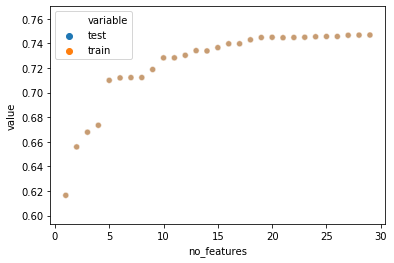

In [49]:
sns.scatterplot(x = 'no_features', y= 'value', hue = 'variable', alpha = 0.5, data = pd.melt(roc_scores_lr, id_vars = 'no_features'))

The above plot shows that train and test scores overlap almost fully - that means that logistic regression is very resilient to overfitting as it didn't occur at all in this case

Best value of AUC is around 0.74. After adding 20 features the outcome is not changing significantly. Now I'm fitting model with that amount of features to obtain true outcome on the held-out test set. 

In [50]:
features = list(minfos_df.head(20).column)
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7453599770557313
AUC for test set  0.7142420227092988


Value of AUC for test set is 0.714 - drop from train set is really small

### Using full GLM model

In [51]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
cols_to_log = [
 'd_lighting_Night with public lighting on',
 'd_lighting_Night without public lighting',
 'd_lighting_Twilight or dawn',
 'd_localization_Out of agglomeration',
 'd_intersection_type_Intersection in T',
 'd_intersection_type_Intersection in X',
 'd_intersection_type_Out of intersection',
 'd_weather_Heavy rain',
 'd_weather_Light rain',
 'd_weather_Normal',
 'd_collision_type_Other collision',
 'd_collision_type_Three or more vehicles - multiple collisions',
 'd_collision_type_Three vehicles and more - in chain',
 'd_collision_type_Two vehicles - by the side',
 'd_collision_type_Two vehicles - from the rear',
 'd_collision_type_Two vehicles - frontal',
 'd_collision_type_Without collision',
 'd_road_category_Departmental Road',
 'd_road_category_Highway',
 'd_road_category_National Road',
 'd_road_regime_NA',
 'd_road_regime_One way',
 'd_road_regime_Separated carriageways',
 'd_reserved_lane_NA',
 'd_reserved_lane_Reserved channel',
 'd_road_gradient_NA',
 'd_road_gradient_Slope',
 'd_road_plan_Curved right',
 'd_road_plan_NA',
 'd_road_plan_Straight part',
 'd_road_condition_normal',
 'd_road_condition_wet',
 'd_infrastructure_Carrefour arranged',
 'd_infrastructure_NA',
 'd_accident_situation_On the road',
 'd_accident_situation_On the verge',
 'd_place_in_car_1',
 'd_place_in_car_2',
 'd_place_in_car_3',
 'd_place_in_car_4',
 'd_place_in_car_NA',
 'd_user_type_Passenger',
 'd_user_type_Pedestrian',
 'd_sex_Male',
 'd_equipment_used_no',
 'd_equipment_used_yes',
 'd_pedestrian_action_not specified or not applicable',
 'd_pedestrian_alone_NA',
 'd_pedestrian_alone_Only',
 'year',
 'month',
 'hour',
 'user_age'
 ]
mod = sm.GLM(y_train['y'],x_train[cols_to_log],family = sm.families.Binomial())
res= mod.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               777937
Model:                            GLM   Df Residuals:                   777884
Model Family:                Binomial   Df Model:                           52
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7698e+05
Date:                Wed, 27 May 2020   Deviance:                   7.5396e+05
Time:                        20:20:24   Pearson chi2:                 7.81e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
d_lighting_Night with public lighting on                          0.1964      0.008     23.157      0.000       0.180       0.213
d_lighting_Night without public lighting                          0.3138      0.011     29.422      0.000       0.293       0.335
d_lighting_Twilight or dawn                                       0.1271      0.012     10.545      0.000       0.103       0.151
d_localization_Out of agglomeration                               0.7760      0.008     96.377      0.000       0.760       0.792
d_intersection_type_Intersection in T                            -0.0613      0.015     -4.014      0.000      -0.091      -0.031
d_intersection_type_Intersection in X                            -0.1418      0.014     -9.865      0.000      -0.170      -0.114
d_intersection_type_Out of intersection                           0.1653      0.012     13.965      0.000       0.142       0.189
d_weather_Heavy rain                                             -0.0800      0.023     -3.508      0.000      -0.125      -0.035
d_weather_Light rain                                             -0.2375      0.016    -15.194      0.000      -0.268      -0.207
d_weather_Normal                                                 -0.1374      0.012    -11.439      0.000      -0.161      -0.114
d_collision_type_Other collision                                 -0.2299      0.740     -0.311      0.756      -1.681       1.221
d_collision_type_Three or more vehicles - multiple collisions    -0.7271      0.740     -0.982      0.326      -2.178       0.724
d_collision_type_Three vehicles and more - in chain              -1.3841      0.741     -1.868      0.062      -2.836       0.068
d_collision_type_Two vehicles - by the side                      -0.3317      0.740     -0.448      0.654      -1.783       1.119
d_collision_type_Two vehicles - from the rear                    -0.7028      0.740     -0.949      0.342      -2.154       0.748
d_collision_type_Two vehicles - frontal                           0.0073      0.740      0.010      0.992      -1.444       1.458
d_collision_type_Without collision                                0.1333      0.740      0.180      0.857      -1.318       1.584
d_road_category_Departmental Road                                 0.6538      0.007     87.924      0.000       0.639       0.668
d_road_category_Highway                                          -0.0160      0.015     -1.043      0.297      -0.046       0.014
d_road_category_National Road                                     0.3869      0.011     33.826      0.000       0.364       0.409
d_road_regime_NA                                                 -0.1176      0.013     -8.83

I will interpret it later on ....


In [52]:
prob = res.predict()
preds = np.array([1 if x<0.5 else 0 for x in prob])
pd.crosstab((y_train['y']),preds)

col_0,0,1
y,,
0,32719,546693
1,56088,142437


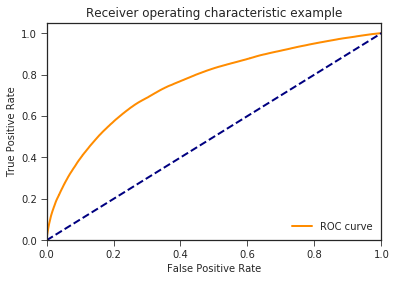

In [53]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train.y, res.predict())
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()

I will interpret it later on ....


### Modeling with SVM

As the dataset is huge - using SVM with other kernel than linear is out of question. Running it on 2 features only, with radial kernel, would take >10 minutes. That is why I have used linear kernel only. Linear kernel is still infeasible to run on the full dataset. Main train dataset has ~7 mln observations, fitting linear svm becomes infeasible at 100 000 obs - at 10 000 the speed is acceptable.

In [54]:
from sklearn.svm import SVC

Reducing train set size - the same random state in x and y gives proper observations

In [55]:
x_train_small = x_train.sample(n = 10000, random_state = 42)
y_train_small = y_train.sample(n = 10000, random_state = 42)

Running SVM on default parameters, best 20 features obtained before are selected.

In [56]:
features = list(minfos_df.head(20).column)
reg = SVC(kernel = 'rbf', probability = True)
reg.fit(x_train_small[features], y_train_small['y'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [57]:
# predsTest = reg.predict_proba(x_test[features])

# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

Above takes very long to run - AUC on test set was 0.625, lower than the best model from logistic regression (0.715)

Trying to find the best c value on the smaller train set with 10 000 observations - obtained above. Number of features is set at 20, as this was correct number shown by Logistic Regression. Again, the kernel is linear.

In [58]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'linear', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_svm.to_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [59]:
roc_scores_svm = pd.read_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

In [60]:
roc_scores_svm

,no_features,test,train
0,0.1,0.677838,0.686063
1,0.5,0.673228,0.680600
2,1.0,0.682514,0.691938
3,1.5,0.697586,0.700556
4,2.0,0.699163,0.703936
5,10.0,0.696553,0.703841


Performance did not improve much - best value was for c = 1.5, and result obtained for test set from cross validation was 0.699. Using the same procedure, fitting SVM with rbf kernel.

In [61]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'rbf', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm_rbf = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
# roc_scores_svm_rbf.to_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [62]:
roc_scores_svm_rbf = pd.read_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

In [63]:
roc_scores_svm_rbf

,no_features,test,train
0,0.1,0.680796,0.700328
1,0.5,0.675718,0.705103
2,1.0,0.678240,0.712834
3,1.5,0.665435,0.709508
4,2.0,0.656149,0.704020
5,10.0,0.631586,0.709276


Performance using radial kernel got even worse than using linear kernel.

### SVM using Stochastic Gradient Descent

Using SGDClassifier with 'hinge' loss, it is equivalent to running standard SVM classifier, but allows for parallel computing. This allows for using full set for training.

In SGD there is parameter alpha performing the regularization. Its relation to c in SVM function is C_svc * n_samples = 1 / alpha_sgd

alpha_sgd = 1 / (C_svc * n_samples)

https://stats.stackexchange.com/questions/216095/how-does-alpha-relate-to-c-in-scikit-learns-sgdclassifier


In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [65]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1)
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [66]:
predsTest = calib_model.predict_proba(x_test[features])
# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for test set  0.6956094845776747


In [67]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train.index.values):
#         n_samples = x_train.iloc[train][features].shape[0]
#         alpha_sgd = 1 / (c * n_samples)
# #         print('computed alpha:', alpha_sgd)
        
#         reg = SGDClassifier(n_jobs = -1, alpha = alpha_sgd)
#         reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         calibrator = CalibratedClassifierCV(reg, cv='prefit')
#         calib_model =calibrator.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         predsTrain = calib_model.predict_proba(x_train.iloc[train][features])
#         preds = calib_model.predict_proba(x_train.iloc[test][features])
        
#         r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_sgd = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_sgd.to_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

In [68]:
roc_scores_sgd = pd.read_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

In [69]:
roc_scores_sgd

,c,test,train
0,0.1,0.732488,0.732324
1,0.5,0.734136,0.734158
2,1.0,0.708720,0.709347
3,1.5,0.733063,0.732837
4,2.0,0.735335,0.735096
5,10.0,0.698826,0.699061


Best alpha is 2.0. Now fitting to the full dataset and checking GOF for test set.

In [70]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1,alpha = 1/(1.5*x_train.shape[0]))
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [71]:
predsTrain = calib_model.predict_proba(x_train[features])
predsTest = calib_model.predict_proba(x_test[features])
print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7333659508315954
AUC for test set  0.7021064816162614


Not much improvement over the LR

### Using Random Forest 

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
features = list(minfos_df.head(20).column)
reg = RandomForestClassifier(n_jobs = -1)
reg.fit(x_train[features], y_train['y'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [74]:
predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7544252659461991
AUC for test set  0.715164627701805


### Feature generation

In [75]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
cols_to_log = [
#  'd_lighting_Night with public lighting on',
 'd_lighting_Night without public lighting',
 'd_lighting_Twilight or dawn',
 'd_localization_Out of agglomeration',
#  'd_intersection_type_Intersection in T',
#  'd_intersection_type_Intersection in X',
 'd_intersection_type_Out of intersection',
#  'd_weather_Heavy rain',
#  'd_weather_Light rain',
 'd_weather_Normal',
 'd_collision_type_Other collision',
#  'd_collision_type_Three or more vehicles - multiple collisions',
#  'd_collision_type_Three vehicles and more - in chain',
#  'd_collision_type_Two vehicles - by the side',
#  'd_collision_type_Two vehicles - from the rear',
 'd_collision_type_Two vehicles - frontal',
 'd_collision_type_Without collision',
 'd_road_category_Departmental Road',
#  'd_road_category_Highway',
#  'd_road_category_National Road',
#  'd_road_regime_NA',
 'd_road_regime_One way',
 'd_road_regime_Separated carriageways',
 'd_reserved_lane_NA',
#  'd_reserved_lane_Reserved channel',
 'd_road_gradient_NA',
#  'd_road_gradient_Slope',
#  'd_road_plan_Curved right',
 'd_road_plan_NA',
 'd_road_plan_Straight part',
 'd_road_condition_normal',
 'd_road_condition_wet',
#  'd_infrastructure_Carrefour arranged',
#  'd_infrastructure_NA',
#  'd_accident_situation_On the road',
 'd_accident_situation_On the verge',
 'd_place_in_car_1',
#  'd_place_in_car_2',
#  'd_place_in_car_3',
#  'd_place_in_car_4',
 'd_place_in_car_NA',
#  'd_user_type_Passenger',
 'd_user_type_Pedestrian',
#  'd_sex_Male',
 'd_equipment_used_no',
#  'd_equipment_used_yes',
 'd_pedestrian_action_not specified or not applicable',
 'd_pedestrian_alone_NA',
#  'd_pedestrian_alone_Only',
#  'year',
#  'month',
 'hour',
 'user_age'
 ]

features = cols_to_log
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7424327552126625
AUC for test set  0.7100542601794027


Value of AUC using features selected by hand is a little bit smaller than using 20 best features from mutual info. Now trying if binning continuous variables will help, as it looked promising in the EDA part.

In [76]:
features = list(minfos_df.head(20).column) + ['hour', 'user_age']
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7450526346085135
AUC for test set  0.7143898146657476


In [77]:
temp_age = pd.concat([x_train[['user_age']], y_train['y']], axis=1)

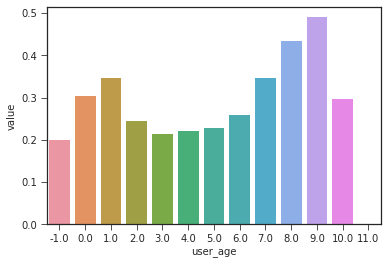

In [78]:
a = pd.crosstab(temp_age['user_age']//10, columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['user_age'], value_vars=[0, 1])

b

sns.barplot(x = 'user_age', y = 'value', data = b.query('y==1'))

The plot above presents percentage of people at given age who were killed. As can be seen there is some regularity - very young and very old people are more likely to die. 

In [79]:
features = list(minfos_df.head(20).column) + ['user_age']

x_train_age = x_train
x_train_age['user_age'] = x_train_age['user_age']/90

x_test_age = x_test
x_test_age['user_age'] = x_test['user_age']/90

reg = LogisticRegression()
reg.fit(x_train_age[features], y_train['y'])

predsTrain = reg.predict_proba(x_train_age[features])
predsTest = reg.predict_proba(x_test_age[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


AUC for train set  0.744709965078145
AUC for test set  0.7141347032208004


In [80]:
features = list(minfos_df.head(20).column) + ['user_age']

for bin_width in [10, 15, 20, 25, 30]:
    print('testing bin width of:', bin_width)
    x_train_age = x_train[features].copy()
    x_train_age['user_age'] = x_train_age['user_age']//bin_width
    x_train_age = pd.concat([x_train_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_train_age['user_age'],drop_first = 1)], axis = 1)

    x_test_age = x_test[features].copy()
    x_test_age['user_age'] = x_test_age['user_age']//bin_width
    x_test_age = pd.concat([x_test_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_test_age['user_age'],drop_first = 1)], axis = 1)


    reg = LogisticRegression()
    reg.fit(x_train_age, y_train['y'])

    predsTrain = reg.predict_proba(x_train_age)
    predsTest = reg.predict_proba(x_test_age)

    print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
    print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))



testing bin width of: 10
AUC for train set  0.74535747109559
AUC for test set  0.7142381447995062
testing bin width of: 15
AUC for train set  0.74535747109559
AUC for test set  0.7142381447995062
testing bin width of: 20
AUC for train set  0.74535747109559
AUC for test set  0.7142381447995062
testing bin width of: 25
AUC for train set  0.74535747109559
AUC for test set  0.7142381447995062
testing bin width of: 30
AUC for train set  0.74535747109559
AUC for test set  0.7142381447995062


Smol improvement!

Benchmark:

- AUC for train set  0.7436704000408136
- AUC for test set  0.7163762566270527



Adding age variable with bin width of 10 really gave an improvement!

#### Now trying to get improvement for hour variable

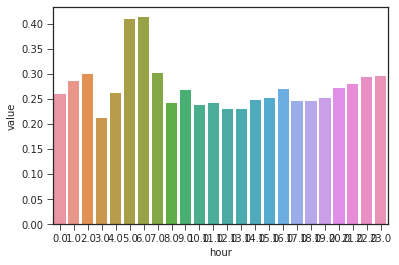

In [81]:
temp_h = pd.concat([x_train[['hour']], y_train['y']], axis=1)
a = pd.crosstab(temp_h['hour'], columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['hour'], value_vars=[0, 1])

b

sns.barplot(x = 'hour', y = 'value', data = b.query('y==1'))

Worst hours are 5, 6 and 7.

In [82]:
features = list(minfos_df.head(20).column) + ['hour']


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7463652329101584
AUC for test set  0.7149223055167289


Even with all hours present the results are better than without them!

In [83]:
features = list(minfos_df.head(20).column) + ['hour']
hours_to_drop = [5,6]


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)
x_train_h.drop(hours_to_drop, axis = 1, inplace = True)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)
x_test_h.drop(hours_to_drop, axis = 1, inplace = True)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7463293411850828
AUC for test set  0.714902540071862
